In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

Импорт библиотек, и создание среды для агента.

In [3]:
env = gym.make('Pong-v0')

NUM_STATES = env.observation_space
NUM_ACTIONS = env.action_space.n

print('States: {}'.format(NUM_STATES))
print('Actions: {}'.format(NUM_ACTIONS))

States: Box(210, 160, 3)
Actions: 6


Создаём модель.

In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        #передаём размер входа и количество действий (на самом деле я думаю что киличество действий можно сократить и передавать только действия которые что-то делают)
        self.input_shape = input_shape
        self.num_actions = num_actions
        #Создаем Sequential для CNN, потомучто я ленивый и мне лень писать forward полностью
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        #Тоже для полносвязного
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
      #вызываем CNN часть, затем вытягиваем всё в один вектор и полносвязная часть
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        #размер входа для полносвязных
        return self.features((torch.zeros(1, *self.input_shape, requires_grad=True))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
      #greedy part, если больше epsilon, то подаём в сеть и находим action. В противном случае рандом
        if random.random() > epsilon:
            state   = torch.cuda.FloatTensor(np.float32(state)).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        #Убираем возможность бесдействовать долго
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

env = NoopResetEnv(env) 

In [6]:
class SkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        #пропускаем фреймы
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break

        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

env = SkipEnv(env, skip=4) 

In [7]:
import cv2

class ChangeFrame(gym.ObservationWrapper):
    def __init__(self, env):
       #Уменьшаем размер и рабираемся со цветом
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]
        
env = ChangeFrame(env)

In [8]:
class ImageToPyTorch(gym.ObservationWrapper):
  #код для переноса каналов на первое место. Из 210, 160, 3 делаем 3, 210, 160
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

env    = wrap_pytorch(env)

In [9]:
env.observation_space

Box(1, 84, 84)

In [10]:
def compute_td_loss(batch_size):
  #берем из буфера рандомный батч
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = (torch.cuda.FloatTensor(np.float32(state)))
    next_state = (torch.cuda.FloatTensor(np.float32(next_state)))
    action     = (torch.cuda.LongTensor(action))
    reward     = (torch.cuda.FloatTensor(reward))
    done       = (torch.cuda.FloatTensor(done))
    not_done   = (1-torch.tensor(done).unsqueeze(1))
   #Вычесляем Q функции 
    q_values      = model(state)
    next_q_values = model(next_state)
    next_q_values_t = model_tar(next_state)*not_done
    #q_value - это тензор q значений для действий которые были произведены. next_q_value - максимальные значение q для следующего состояния. expected_q_value - ожидаемые по формуле
    q_value         = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_q_value     = next_q_values.max(1)[0]
    next_q_value     = next_q_values_t.gather(1, torch.argmax(next_q_values, dim=1).unsqueeze(1)).detach().squeeze()
    expected_q_value = reward + gamma * next_q_value

   #считаем квадрат ошибки, берём среднее значение по батчу
    loss = (q_value - (expected_q_value.detach())).pow(2).mean()
   #Зануляем градиенты, пробрасываем loss и делаем шаг оптимизатора     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
model = CnnDQN(env.observation_space.shape, env.action_space.n)
#передаём всё на GPU если оно работает
if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 10000

In [12]:
#ddqn

model_tar = CnnDQN(env.observation_space.shape, env.action_space.n)
if torch.cuda.is_available():
    model_tar = model_tar.cuda()

model_tar.eval()

CnnDQN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [13]:
from collections import deque

class ReplayBuffer(object):
  #Это буфер, push забивает в буфер всю необходимую информацию, sample вытаскивает рандомное вхождение
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):           
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (state), action, reward, (next_state), done
    
    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(100000)

In [14]:
import math, random
#эпсилан-функиция, уменьшаем со временем по экспоненте
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot(frame_idx, rewards, losses):
  #визуализация
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

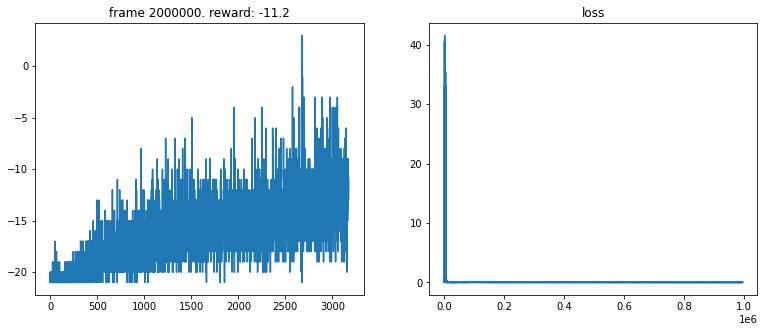

In [17]:
num_frames = 2000000
batch_size = 64
gamma      = 0.99
target_update = 10000

losses = []
all_rewards = []
episode_reward = 0
#ставим агента в начальное положение
state = env.reset()
for frame_idx in range(1, num_frames + 1):
  #считаем epsilon и action
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
  #делаем шаг и отправляем информацию в буфер  
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
  #если победа, то заново  
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
   #Если буффер больше  replay_initial то обучаемся
    if len(replay_buffer) > replay_initial and frame_idx%2==0:
        loss = compute_td_loss(batch_size)
        losses.append(loss.detach().item())
    #double dqn
    if frame_idx % target_update == 0:
      with torch.no_grad():
        model_tar.load_state_dict(model.state_dict())
        model_tar.eval()
   #вывод графиков     
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

In [31]:
totalReward = 0
state = env.reset()

for frame_idx in range(1, 10000):
    #epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, 0)
    
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    totalReward += reward
    if done:      
        break

print(totalReward)

-9.0
